**Overview:**
 - Refactor some of the work from @jlln DependencyTreeExperiments3, in particular DependencyTreeExperiments3
 - Replace some of the loops with separate functions for processing Articles, Sentences and Sentence Branches
 - While processing a particular article, keep track of the most recent place names and locations found which can then be used as default values for future reports
 - Extend the search for reporting units over all children of the reporting term
 - Make no assumptions about whether the numerical term is a child or parent of the reporting unit (there are examples of both
 
**Testing:**
- Evaluate any performance gains by counting the number of articles for which 0 stories are encountered in the training set
- Prior to refactoring, 137 of 291 articles returned 0 stories
- After refactoring, 82 of 291 articles returned 0 stories

**Future work**
 - In addition to work already identified by @jlln, need to evaluate the accuracy of each story identified with this new approach
 - In some cases the linkages between reporting terms and reporting units are too broad, for exampling associating 'houses' with being 'killed'
 - Need to evaluate whether parse tree dependency labels need to be take into account

In [1]:
import pandas as pd
import spacy
import os
import sys
from nltk import Tree
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
nlp = spacy.load('en')

def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_

In [3]:
def remove_newline(text):
    ''' Removes new line and &nbsp characters.
    '''
    text = text.replace('\n', ' ')
    text = text.replace('\xa0', ' ')
    return text

In [4]:
test_data = pd.read_csv('../data_extract/article_contents.csv') #Connecting to pre-populated dataset.
test_data['content'] = test_data['content'].apply(lambda x: (remove_newline(str(x))))

In [5]:
person_reporting_terms = [
    'displaced', 'evacuated', 'forced flee', 'homeless', 'relief camp',
    'sheltered', 'relocated', 'stranded','stuck','stranded',"killed","dead","died"
]

structure_reporting_terms = [
    'destroyed','damaged','swept','collapsed','flooded','washed'
]

person_reporting_units = ["families","person","people","individuals","locals","villagers","residents","occupants","citizens", "households"]

structure_reporting_units = ["home","house","hut","dwelling","building","shop","business","apartment","flat","residence"]


person_term_lemmas = [t.lemma_ for t in nlp(" ".join(person_reporting_terms))]
structure_term_lemmas = [t.lemma_ for t in nlp(" ".join(structure_reporting_terms))]
person_unit_lemmas = [t.lemma_ for t in nlp(" ".join(person_reporting_units))]
structure_unit_lemmas = [t.lemma_ for t in nlp(" ".join(structure_reporting_units))]

reporting_term_lemmas = person_term_lemmas + structure_term_lemmas
reporting_unit_lemmas = person_unit_lemmas + structure_unit_lemmas

In [6]:
class Report:
    def __init__(self,locations,date_time,event_term,subject_term,quantity,story):
        self.locations = locations
        self.date_time = date_time
        self.event_term = [t.lemma_ for t in nlp(event_term)][0]
        self.subject_term = subject_term
        self.quantity = quantity
        self.story = story
    
    def display(self):
        print("Location: {}  DateTime: {}  EventTerm: {}  SubjectTerm:  {}  Quantity: {}"
              .format(self.locations,self.date_time,self.event_term,self.subject_term,self.quantity))
        
    def show_story_tree(self):
        self.display()
        for sentence in nlp(self.story).sents:
            for token in sentence:
                if token.lemma_ == self.event_term:
                    return to_nltk_tree(sentence.root)

In [9]:
def test_token_equality(token_a,token_b):
    if token_a.text == token_b.text:
        return True
    else:
        return False
    
def check_if_collection_contains_token(token,collection):
    if any([test_token_equality(token,t) for t in collection]):
        return True
    else:
        return False

def get_descendents(sentence,root=None):
    """
    Retrieves all tokens that are descended from the head of the specified root token.
    param: root: the root token
    param: sentence: a span from which to retrieve tokens.
    returns: a list of tokens
    """
    if not root:
        root = sentence.root
    else:
        root = root.head
    return [t for t in sentence if root.is_ancestor_of(t)]
    
def check_if_entity_contains_token(tokens,entity):
    """
    Function to test if a given entity contains at least one of a list of tokens.
    param: tokens: A list of tokens
    param: entity: A span
    
    returns: Boolean
    """
    tokens_ = [t.text for t in tokens]
    ret = False
    for token in entity:
        if token.text in tokens_:
            return True
    return False
    

def get_distance_from_root(token,root):
    """
    Gets the parse tree distance between a token and the sentence root.
    :param token: a token
    :param root: the root token of the sentence
    
    returns: an integer distance
    """
    if token == root:
        return 0
    d = 1
    p = token.head
    while p is not root:
        d+=1
        p = p.head
    return d


def get_common_ancestors(tokens):
    ancestors = [set(t.ancestors) for t in tokens]
    if len(ancestors) == 0:
        return []
    common_ancestors = ancestors[0].intersection(*ancestors)
    return common_ancestors
    

def get_contiguous_tokens(token_list):
    common_ancestor_tokens = get_common_ancestors(token_list)
    highest_contiguous_block = []
    for toke in token_list:
        if check_if_collection_contains_token(toke.head,common_ancestor_tokens):
            highest_contiguous_block.append(toke)
    added_tokens = 1
    while added_tokens > 0:
        added_tokens = 0
        for toke in token_list:
            if check_if_collection_contains_token(toke.head,highest_contiguous_block):
                if not check_if_collection_contains_token(toke,highest_contiguous_block):
                    highest_contiguous_block.append(toke)
                    added_tokens +=1
    return highest_contiguous_block

def match_entities_in_block(entities,token_block):
    matched = []
    text_block = [t.text for t in token_block] #For some reason comparing identity on tokens does not always work.
    for e in entities:
        et = [t.text for t in e]
        et_in_b = [t for t in et if t in text_block]
        if len(et_in_b) == len(et):
            matched.append(e)
    return matched

def extract_locations(sentence,root=None):
    """
    Examines a sentence and identifies if any of its constituent tokens describe a location.
    If a root token is specified, only location tokens below the level of this token in the tree will be examined. 
    If no root is specified, location tokens will be drawn from the entirety of the span.
    param: sentence       a span
    param: root           a token
    returns: A list of strings, or None
    """
    if not root:
        root = sentence.root
    descendents = get_descendents(sentence,root)
    location_entities = [e for e in nlp(sentence.text).ents if e.label_ == "GPE"]
    if len(location_entities) > 0:
        descendent_location_tokens = []
        for location_ent in location_entities:
            if check_if_entity_contains_token(location_ent,descendents):
                descendent_location_tokens.extend([token for token in location_ent])
        contiguous_token_block = get_contiguous_tokens(descendent_location_tokens)

        block_locations = match_entities_in_block(location_entities,contiguous_token_block)
        return [location.text for location in block_locations]
    else:
        return []
    
def extract_dates(sentence,root=None):
    """
    Examines a sentence and identifies if any of its constituent tokens describe a date.
    If a root token is specified, only date tokens below the level of this token in the tree will be examined. 
    If no root is specified, date tokens will be drawn from the entirety of the span.
    param: sentence       a span
    param: root           a token
    returns: A list of strings, or None
    """
    if not root:
        root = sentence.root
    descendents = get_descendents(sentence,root)
    date_entities = [e for e in nlp(sentence.text).ents if e.label_ == "DATE"]
    if len(date_entities) > 0:
        descendent_date_tokens = []
        for date_ent in date_entities:
            if check_if_entity_contains_token(date_ent,descendents):
                descendent_date_tokens.extend([token for token in date_ent])
        contiguous_token_block = get_contiguous_tokens(descendent_date_tokens)

        block_dates = match_entities_in_block(date_entities,contiguous_token_block)
        return [location.text for location in block_dates]
    else:
        return []

def find_reports(story):
    """
    Core function for extracting reports from a news story.
    :param story: A string containing the text to be parsed.
    
    returns: A list of Report objects.
    """
    reports = []
    sentences = list(nlp(story).sents)
    for i,sentence in enumerate(sentences):
        for token in sentence:
            if token.lemma_ in reporting_term_lemmas:
                term_token = token
                children = term_token.children
                unit_children = list(filter(lambda x: x.lemma_ in reporting_unit_lemmas,children))
                possible_locations = extract_locations(sentence,token)
                possible_dates = extract_dates(sentence,token)
                if i > 0:
                    if len(possible_dates) == 0:
                        possible_dates = extract_dates(sentences[i-1])
                    if len(possible_locations) == 0:
                        possible_locations = extract_locations(sentences[i-1])
                for uc in unit_children:
                    uc_children = uc.children
                    for token in uc_children:
                        if token.like_num:
                            number = token.text
                            reporting_unit = uc.text
                            reporting_term = term_token.text
                            report = Report(possible_locations,possible_dates,reporting_term,reporting_unit,number,story)
                            reports.append(report)
                            #report.display()
                if len(unit_children) == 0:
                    for token in children:
                        if token.like_num:
                            number = token.text
                            reporting_unit = "person-implicit"
                            reporting_term = term_token.text
                            report = Report(possible_locations,possible_dates,reporting_term,reporting_unit,number,story)
                            reports.append(report)
                            #report.display()
    return reports

### Using current approach how many articles return 0 stories

In [10]:
test_data['num_stories'] = test_data['content'].apply(lambda x: len(find_reports(x)))
print("{} out of {} articles have 0 stories".format((test_data['num_stories'] == 0).sum(), len(test_data)))

134 out of 291 articles have 0 stories


### Look at some sentences:

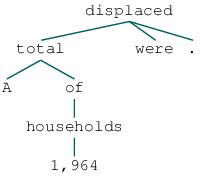

In [11]:
sentence = list(nlp("A total of 1,964 households were displaced.").sents)[0]
to_nltk_tree(sentence.root)

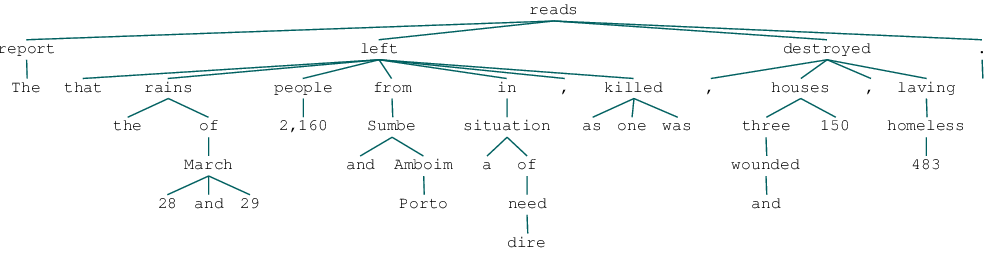

In [12]:
sentence = list(nlp('The information is contained in a report on the consequences of the rains, released by the Civil Protection commission for the municipalities of Sumbe and Porto Amboim.  According to the report presented by the secretary of State for Local Administration, Fernando Pontes Pereira, who travelled to the region for the purpose, the situation requires strong measures to relocate the people affected into safer places.  The report reads that the rains of March 28 and 29 left 2,160 people from Sumbe and Porto Amboim in a situation of dire need, as one was killed, three wounded and 150 houses destroyed, laving 483 homeless.  The source adds that Cuanza Sul Government is currently busy transferring those affected to safer places in the localities of Pomba Nova , near Sumbe, where tents have been installed for the purpose.').sents)[-2]
to_nltk_tree(sentence.root)

### Try modified approach with refactoring    
    

In [25]:
def extract_locations(sentence,root=None):
    """
    Examines a sentence and identifies if any of its constituent tokens describe a location.
    If a root token is specified, only location tokens below the level of this token in the tree will be examined. 
    If no root is specified, location tokens will be drawn from the entirety of the span.
    param: sentence       a span
    param: root           a token
    returns: A list of strings, or None
    """
    if not root:
        root = sentence.root
    descendents = get_descendents(sentence,root)
    location_entities = [e for e in nlp(sentence.text).ents if e.label_ == "GPE"]
    if len(location_entities) > 0:
        descendent_location_tokens = []
        for location_ent in location_entities:
            if check_if_entity_contains_token(location_ent,descendents):
                descendent_location_tokens.extend([token for token in location_ent])
        contiguous_token_block = get_contiguous_tokens(descendent_location_tokens)

        block_locations = match_entities_in_block(location_entities,contiguous_token_block)
        return [location.text for location in block_locations]
    else:
        return None
    
def extract_dates(sentence,root=None):
    """
    Examines a sentence and identifies if any of its constituent tokens describe a date.
    If a root token is specified, only date tokens below the level of this token in the tree will be examined. 
    If no root is specified, date tokens will be drawn from the entirety of the span.
    param: sentence       a span
    param: root           a token
    returns: A list of strings, or None
    """
    if not root:
        root = sentence.root
    descendents = get_descendents(sentence,root)
    date_entities = [e for e in nlp(sentence.text).ents if e.label_ == "DATE"]
    if len(date_entities) > 0:
        descendent_date_tokens = []
        for date_ent in date_entities:
            if check_if_entity_contains_token(date_ent,descendents):
                descendent_date_tokens.extend([token for token in date_ent])
        contiguous_token_block = get_contiguous_tokens(descendent_date_tokens)

        block_dates = match_entities_in_block(date_entities,contiguous_token_block)
        return [location.text for location in block_dates]
    else:
        return None

def get_all_descendent_tokens(token):
    """
    Returns a list of all descendents of the specified token.
    """
    children_accum = []
    for child in token.children:
        children_accum.append(child)
        grandchildren = get_all_descendent_tokens(child)
        children_accum.extend(grandchildren)
    return children_accum

def process_branch(token):
    '''Examines a branch (defined as token and all of its children)
    to see if any tokens are number-like and / or reporting units
    If a reporting_unit is found, returns the identified unit and any
    identified numbers
    param: token       a token
    return: reporting_unit, number or None, None
    '''
    children = [token] + get_all_descendent_tokens(token)
    reporting_unit, number = None, None
    for child in children:
        if child.like_num:
            number = child.text
        elif child.lemma_ in reporting_unit_lemmas:
            reporting_unit = child.text
    return reporting_unit, number

def process_article(story):
    '''Process an article by splitting it into sentences and
    calling process_sentence for each sentence
    Keep a running track of identified dates and locations that
    can be used as default values for reports that have no date
    or location
    param: story       string
    return: list of reports
    '''
    processed_reports = []
    sentences = list(nlp(story).sents) # Split into sentences
    last_date = None # Keep a running track of the most recent date found in articles
    last_location = None # Keep a running track of the most recent location found in articles
    for sentence in sentences: # Process sentence
        report = process_sentence(sentence, story)
        if report:
            if report.date_time:
                last_date = report.date_time
            else:
                report.date_time = last_date
            if report.locations:
                last_location = report.locations
            else:
                report.locations = last_location
            processed_reports.append(report)
    return processed_reports

def process_sentence(sentence, story):
    '''Process a sentence to try and find any reports contained
    within it.
    First try and find a reporting_term; if it exists identify any
    locations and dates.
    Finally, look within all branches below the reporting_term to
    try and identify a relevant reporting unit and number.
    If a minimum of a reporting_term and reporting_unit exist, 
    then create a report.
    param: sentence Spacy sentence
    return: report
    '''
    for token in sentence:
        if token.lemma_ in reporting_term_lemmas:
            term_token = token
            possible_locations = extract_locations(sentence,token)
            possible_dates = extract_dates(sentence,token)
            reporting_term = term_token.text 
            children = term_token.children
            for child in children:
                reporting_unit, number = process_branch(child)
                if reporting_unit:
                    report = Report(possible_locations,possible_dates,reporting_term,reporting_unit,number,story)
                    return report

In [26]:
article = 'The information is contained in a report on the consequences of the rains, released by the Civil Protection commission for the municipalities of Sumbe and Porto Amboim.  According to the report presented by the secretary of State for Local Administration, Fernando Pontes Pereira, who travelled to the region for the purpose, the situation requires strong measures to relocate the people affected into safer places.  The report reads that the rains of March 28 and 29 left 2,160 people from Sumbe and Porto Amboim in a situation of dire need, as one was killed, three wounded and 150 houses destroyed, laving 483 homeless.  The source adds that Cuanza Sul Government is currently busy transferring those affected to safer places in the localities of Pomba Nova , near Sumbe, where tents have been installed for the purpose.'
for report in process_article(article):
    report.display()

Location: None  DateTime: None  EventTerm: relocate  SubjectTerm:  people  Quantity: None
Location: ['Sumbe']  DateTime: ['March 28']  EventTerm: destroy  SubjectTerm:  houses  Quantity: 150


In [27]:
article = "A total of 1,964 households were displaced."
for report in process_article(article):
    report.display()

Location: None  DateTime: None  EventTerm: displace  SubjectTerm:  households  Quantity: 1,964


### How does this new approach do in terms of identifying stories:

In [28]:
test_data['num_stories'] = test_data['content'].apply(lambda x: len(process_article(x)))

In [29]:
print("{} out of {} articles have 0 stories".format((test_data['num_stories'] == 0).sum(), len(test_data)))

82 out of 291 articles have 0 stories


In [30]:
for i, row in test_data.iloc[:100].iterrows():
    print("=============Story================")
    print(row['content'])
    print("=============Reports================")
    reports = process_article(row['content'])
    for report in reports:
        report.display()

=============Story================
Flash flooding across Afghanistan and Pakistan has left more than 160 dead and dozens stranded in one of South Asia's worst natural disasters this year, say officials.  The flooding, caused by unusually heavy rain, has left villagers stuck in remote areas without shelter, food or power.  Mountainous Afghanistan was the worst hit, with 61 people killed and approximately 500 traditional mud-brick homes washed away in more than a dozen villages in Sarobi, a rural district less than an hour from Kabul, officials said.  Floods left a village devastated in the remote eastern Afghan province of Nuristan. At least 60 homes were destroyed across three districts, said provincial spokesman Mohammad Yusufi. No one was killed.  Authorities have been unable to deliver aid to some badly affected villages by land as roads in the area are controlled by the Taliban, Yusufi added.  “We have asked the national government for help as have an overwhelming number of locals 